In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
from sklearn import preprocessing,metrics,manifold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
from imblearn.over_sampling import ADASYN,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import collections
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import RobustScaler
import xgboost
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
from collections import Counter
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.metrics import classification_report,confusion_matrix
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [ ]:
train_df=pd.read_csv('../input/google-quest-challenge/train.csv')
train_df.head()

## Time for some Cleaning!

Before we move ahead , let us clean the dataset and remove the redundancies.This includes

- HTML codes
- URLs
- Emojis
- Stopwords
- Punctuations
- Expanding Abbreviations

These will be sufficient for cleaning the corpus!

[Regex](https://docs.python.org/3/howto/regex.html) is a very good tool which will help us to do this cleaning.

In [ ]:
%%time
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#train_df['question_body']=train_df['question_body'].apply(lambda z: remove_punctuations(z))

train_df['question_body']=train_df['question_body'].apply(lambda z: remove_html(z))
train_df['question_body']=train_df['question_body'].apply(lambda z: remove_url(z))
train_df['question_body']=train_df['question_body'].apply(lambda z: remove_emoji(z))

train_df['answer']=train_df['answer'].apply(lambda z: remove_punctuations(z))

train_df['answer']=train_df['answer'].apply(lambda z: remove_html(z))
train_df['answer']=train_df['answer'].apply(lambda z: remove_url(z))
train_df['answer']=train_df['answer'].apply(lambda z: remove_emoji(z))


## Vectorization - TFIDF and Count


We will move ahead with TFIDF and Count vectorization strategies and will be going in further sections.

- [TF-IDF Vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html): This works by applying a logarithmic term to inverse document frequency (IDF) part other than determining the "TF" or term freqency part. The formulation can be shown as follows:

<img src="https://plumbr.io/app/uploads/2016/06/tf-idf.png">


-[Count Vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html): This is a simpler vectorization technique which relies on frequency of occurence of a particular term in a document or corpus.
A pictorial representation about the way in which vectorization occurs is provided:

<img src="https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/assets/atap_0408.png">



In [ ]:
%%time
def tfidf_transform(sample):
    tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
    return tfidf.fit_transform(sample),tfidf
tfidf_qtransform,qmodel=tfidf_transform(train_df['question_body'].values.tolist())
q_dictionary=dict(zip(qmodel.get_feature_names(),list(qmodel.idf_)))
tfidf_atransform,amodel=tfidf_transform(train_df['answer'].values.tolist())
a_dictionary=dict(zip(amodel.get_feature_names(),list(amodel.idf_)))
tfidf_qtransform.shape
tfidf_atransform.shape

## Converting to Dense Vectors

After transforming the tfidf vectors, we are using the Dense vector representation to attain the question-answer level semantic similarity statistics. For this we follow the steps:

- Retrieve the Dense Representation of the Question and Answer pairs
- Visualize the tfidf embeddings
- Compute the Cosine distance between the question and answer pair using the tfidf embeddings


In [ ]:
tfidf_qvect=qmodel.fit(train_df['question_body'].values.tolist())
final_qtfidf=tfidf_qvect.transform(train_df['question_body'].values.tolist())
tfidf_avect=amodel.fit(train_df['answer'].values.tolist())
final_atfidf=tfidf_avect.transform(train_df['answer'].values.tolist())
#print(final_qtfidf)
print(final_atfidf.todense())


## Visualizing the vector space

In this case, we are visualizing the vector space for 10 tfidf embeddings

In [ ]:
dense_avector=final_atfidf.todense()
print(dense_avector.shape)
plt.plot(dense_avector[0:10])
plt.show()
dense_qvector=final_qtfidf.todense()
print(dense_qvector.shape)
plt.plot(dense_qvector[0:10])
plt.show()


In [ ]:
'''Compute Cosine distance similarity from the tfidf vectors'''
from scipy.spatial.distance import cosine
cosine_dist=[]
for i in range(100):
    distance=1-cosine(dense_avector[100],dense_avector[i])
    cosine_dist.append(distance)
plt.plot(cosine_dist)
plt.show()

## Visualizing the Vector Space


As words and sentences are vectorized, the dimensions of the vector space becomes significantly large to be accomodated in a model. For any computation system it is recommended to keep the dimensions of a tensor (matrix) as small as possible and maintain its regularity. For tensors with larger dimensions and irregular shapes, it is difficult for the system to perform any operation (matrix /tensor multiplication etc.). Complex operations like tensor differentiation (Jacobian) or numerical approximation is another difficult thing to do for large matrices. The rank plays an important aspect for these operations.

Now, we have to reduce the dimensions ,else the kernel will run out of memory. For this we wmploy 3 different decomposition techniques:

- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)


These algorithms rely on Eigen vector decomposition and Eigen matrices for creating smaller matrices. These reduced matrices are well-fitted to perform any numerical approximation tasks from differentiation to higher order non linear dynamics. [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) in general is a well known method and forms the base of all decomposition techniques. Pictorially it operates as follows with the help of orthogonal Eigen vectors


<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_ica_vs_pca_thumb.png">


TSNE is a more sophisticated [method](https://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf) which uses a non convex optimization along with gradient descent. This is different than Eigen Vector (convex optimization) method of PCA and hence different results may be obtained in different iterations. It is a memory intensive method and is often powerful at the expense of longer execution time.

<img src="https://46gyn61z4i0t1u1pnq2bbk2e-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/t-sne-plot-300x275.png">



In [ ]:
'''Function for reduction of tfidf dimensions with labelled set'''

def dimen_reduc_plot(test_data,test_label,option):
    tsvd= TruncatedSVD(n_components=2,algorithm="randomized",random_state=42)
    tsne=TSNE(n_components=2,random_state=42) #not recommended instead use PCA
    pca=SparsePCA(n_components=2,random_state=42)
    if(option==1):
        tsvd_result=tsvd.fit_transform(test_data)
        plt.figure(figsize=(10,8))
        colors=['orange','red']
        sns.scatterplot(x=tsvd_result[:,0],y=tsvd_result[:,1])
        
        plt.show()
        plt.figure(figsize=(10,10))
        '''
        plt.scatter(tsvd_result[:,0],tsvd_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Negative Review')
        color_orange=mpatches.Patch(color='orange',label='Positive Review')
        plt.legend(handles=[color_orange,color_red])
        plt.title("TSVD")
        plt.show()
         '''
    if(option==2):
        tsne_result=tsne.fit_transform(test_data)
        plt.figure(figsize=(10,8))
        colors=['orange','red']
        sns.scatterplot(x=tsne_result[:,0],y=tsne_result[:,1])
        plt.show()
        plt.figure(figsize=(10,10))
        '''
        plt.scatter(x=tsne_result[:,0],y=tsne_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Negative Review')
        color_orange=mpatches.Patch(color='orange',label='Positive Review')
    
        plt.legend(handles=[color_orange,color_red])
        plt.title("PCA")
        plt.show()
        '''
    if(option==3):
        pca_result=pca.fit_transform(test_data)
        plt.figure(figsize=(10,8))
        colors=['orange','red']
        sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1])
        plt.show()
        plt.figure(figsize=(10,10))
        '''
        plt.scatter(x=pca_result[:,0],y=pca_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Negtive Review')
        color_orange=mpatches.Patch(color='orange',label='Positive Review')
        plt.legend(handles=[color_orange,color_red])
        plt.title("TSNE")
        plt.show()
        '''
test_data=dense_qvector[0:400]
test_label=dense_avector[0:400]
dimen_reduc_plot(test_data,test_label,1)
dimen_reduc_plot(test_data,test_label,2)
#dimen_reduc_plot(test_data,test_label,3)


## Creating Weighted TFIDF Sentence Vectors

In this case, we are using tfidf ranking to get sentence vectors, and attain the embeddings. The first step is the decomposition of the ttfidf transform into a word level dictionary which can be used for lookup purposes. If the word is present in the dictionary, we get the idf score for that particular word and apply a weighted semantic on top of it. Once the vectors for a particular sentence have been collected, we use a mean pool method to get the final embedding feature for that word.

- Decompose the TFIDF transform into dictionary
- Check for each word if it is present in the dictionary
- Apply a weighted metric on the idf score
- Add all the values and pool them
- Return the final embedding (TFIDF)

In [ ]:
from tqdm import tqdm
import concurrent.futures
import tensorflow as tf

def vectorize(word,features,lookup,corp,val,vec):
    if word in features:
        metric=lookup[word]*((corp.count(word)/len(corp)))
        #metric=lookup[word]*(tf.math.log(corp.count(word)/len(corp)))
        #metric=metric.numpy()
        val+=metric
        vec+=(metric)
    return val,vec
def create_vectors(model,content,dictionary):
    model_features=model.get_feature_names()
    model_vectors=[]
    for corp in tqdm(content):
        vec=np.zeros(100)
        val=0
        
        '''
        futures_list=[]
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for word in tqdm(corp):
                futures=executor.submit(vectorize,word,model_features,dictionary,corp,val,vec)
                futures_list.append(futures)
            for future in futures_list:
                
                val,vec = future.result()
                if val!=0:
                    vec/=val
                model_vectors.append(vec)
        '''
        for word in (corp):
            val,vec=vectorize(word,model_features,dictionary,corp,val,vec)
            #print(vec)
        if val!=0:
            vec/=val
        model_vectors.append(vec)
        
    return model_vectors    

'''generate tfidf embedding vectors for question corpus'''
dictionary=q_dictionary
model=qmodel
content=train_df['question_body'][:10].values.tolist()
tfidf_embedding=create_vectors(model,content,dictionary)
#print(tfidf_embedding)

## Word2vec Variant Embeddings

In this context, we will be looking into w2v embeddings.

Word Embeddings: These are vector space transformations of the words present in the corpus. When converted to vectors, several metrics can be applied like finding similarity, distance measurement between the vectors, numerical transforms of the vectors. With word vectors, we can specify semantic similarity between different words or collection of words. A pictorial representation of word vectors compressed with Dimension reduction methods is [provided below](https://www.tensorflow.org/tutorials/text/word_embeddings):


<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1">

## Word2vec Embeddings

These embeddings are pre-trained on large corpuses like Wikipedia, News corpuses.etc. However, the base of these algorithms rely on 2 important techniques:

- [Skipgram](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

<img src="https://miro.medium.com/max/1580/0*xqhh7Gd64VAQ1Sny.png">

- [Common Bag of Words Model](https://analyticsindiamag.com/the-continuous-bag-of-words-cbow-model-in-nlp-hands-on-implementation-with-codes/)

<img src="https://cdn-images-1.medium.com/max/800/1*UVe8b6CWYykcxbBOR6uCfg.png">

This blog by [Lilian](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html) is a great introduction.

The Skipgram approach tries to predict contextual words and phrases given a single word, whereas the CBOW approach tries to predict a single correct word given the context.

[Jay's blog](http://jalammar.github.io/mit-analytics-lab-talk/) is a great resource for more learning!


## Word2Vec and its variants

[Word2Vec](https://arxiv.org/abs/1301.3781) is one of the traditional algorithms which was emphasized based on Heirarchical Softmax as well as with simplistic RNNs. [Gensim](https://radimrehurek.com/gensim/models/word2vec.html) provides a great way to use and start with Word2Vec. The Word2Vec algorithm builds by using the Skipgram model as well as the Common Bag of Words Model. Both the models are described in the links.

Some references:

- [Nathan's blog](https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/)
- [Illya's paper](https://arxiv.org/abs/1310.4546)
- [Jason's Blog](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)
- [Advanced Resource](https://adventuresinmachinelearning.com/word2vec-keras-tutorial/)

An overview of hte sipgram process:

<img src="https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/skip-gram-architecture.png">

Huffman Algorithm forms the base of Hierarchical softmax based [Word2vec algorithm](https://leimao.github.io/article/Hierarchical-Softmax/). This uses the huffman coding algorithm for compression.

<img src="https://miro.medium.com/proxy/1*a4idodtq60y2U5HqpB_MTQ.png">

[This resource](https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281) is also helpful.


Word2vec uses a skipgram with negative sampling to enhance the logistic regression values of the model, which in turn leads to better classifications of the embeddings.[Blog](http://jalammar.github.io/illustrated-word2vec/)


<img src="http://jalammar.github.io/images/word2vec/skipgram-language-model-training-5.png">

## Visualizing Vectors in Projector

Contextual word vectors are very large and they are determined with respect to the surrounding context.Visualizing large dimension tensors or vectors are computatinally very difficult. By lowering the dimension, the implication is that there is a tensor decomposition based on the above mentioned algorithms. Tensor decomposition is based on rank specifications of a tensor or matrix. Based on rank, these reductions rely on reducing the effective rank based on the number of components we would want to visualize. When we specify the number of components we would want the tensor to be compressed into, the effective rank reduction takes place by Eigen vector decomposition (which is a numerical method).

The TSNE, being a gradient descent based algorithm, takes up a lot of computation space when tried with large amounts of data. This leads to exhaustive memory consumption.In this case, a better solution would be to batch process the data, before passing it to the TSNE compressor. Tensorflow provides Projector which is really helpful for visualizing different embedding vectors which we will be going into. A visualization of the same is provided:

<img src="https://i.imgur.com/3tTpr4d.png">

[Projector](https://projector.tensorflow.org/)


In [ ]:

from gensim.models import Word2Vec,KeyedVectors
question_corpus=list(train_df['question_body'].str.split())
model=Word2Vec(question_corpus,min_count=1)
word_li=list(model.wv.index_to_key)
print(word_li[:5])
def save_and_load_model(model,word1,word2):
    model.save('word2vec_model.bin')
    loaded_model=KeyedVectors.load('word2vec_model.bin')
    def measure_cosine():
        distance=model.wv.similarity(word1,word2)
        return distance
    def plot_vector(vector):
        plt.plot(model.wv[vector])
        plt.show()
    plot_vector(word1)
    plot_vector(word2)
    return model,measure_cosine()
_,distance=save_and_load_model(model,'photography','camera')
print(distance)

## Sentence Vectors with Word2vec

In this case, we will be applying sentence vectors using Word2Vec:

- For each sentence in the question and answer corpus, extract the word level embeddings from the Word2Vec algorithm
- For each sentence embedding tensor provided, calculate by average pooling the sentence vector
- Compare each question pair with the answer pair and apply cosine distance similarity


In [ ]:
from tqdm import tqdm
import concurrent.futures
import tensorflow as tf


def create_w2vvectors(model,content):
    w2vmodel_vectors=[]
    for corp in tqdm(content):
        vec=np.zeros(100)
        val=0
        for word in (corp):
            if word in model.wv.index_to_key:
                vec+=model.wv[word]
                val+=1
            #print(vec)
        if val!=0:
            vec/=val
        w2vmodel_vectors.append(vec)
        
    return w2vmodel_vectors    

'''generate w2v  sentence embedding vectors for question-answer corpus'''
qcontent=train_df['question_body'][:10].values.tolist()
w2v_qsent_embedding=create_w2vvectors(model,qcontent)
acontent=train_df['answer'][:10].values.tolist()
w2v_asent_embedding=create_w2vvectors(model,acontent)


In [ ]:
def w2v_simi(w2v_qsent_embedding,w2v_asent_embedding,inp):
    cosine_dist=[]

    for i in range(inp):
        distance=1-cosine(w2v_qsent_embedding[i],w2v_asent_embedding[i])
        cosine_dist.append(distance)
    plt.plot(cosine_dist)
    plt.show()
    w2v_cosine=pd.DataFrame(columns=['Question','Answer','W2V_Similarity'])
    w2v_cosine['Question']=qcontent
    w2v_cosine['Answer']=acontent
    w2v_cosine['W2V_Similarity']=cosine_dist
    w2v_cosine.head()
    return w2v_cosine
w2v_cosine=w2v_simi(w2v_qsent_embedding,w2v_asent_embedding,10)
w2v_cosine.head()

## Dimension reduction of the embedding vectors

Let us try to visualize the compressed and decomposed embedding space based on first 50 entries in the dataset.Once we plot using the Word2Vec Skipgram/CBOW model, we can visualize the relative positioning of the words close to each other. The famous example using "kings","queens" is provided below:

<img src="https://miro.medium.com/max/327/1*keqyBCQ5FL6A7DZLrXamvQ.png">

Cosine Distance measurement is one metric which determines closeness of the 2 word vectors.When we plot vectors using matplotlib, we will be seeing graphs like ECG(electro-cardiograms) diagrams. The reason being each word is analysed on the basis of the number of words in its surrounding words.

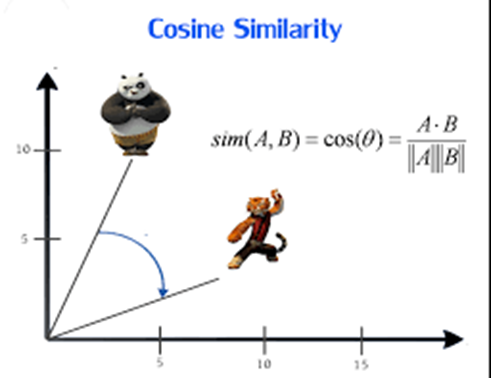

In [ ]:
from matplotlib import pyplot
def display_distance(loaded_model,num,x,y):
    pca = PCA(n_components=2)
    transformation_model=loaded_model.wv[loaded_model.wv.index_to_key]
    result = pca.fit_transform(transformation_model[:num])
    pyplot.figure(figsize=(x,y))
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(loaded_model.wv.index_to_key)
    for i, word in enumerate(words[:num]):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()
display_distance(model,10,5,5)    

## Working with Glove Embeddings

Glove embeddings rely on global vector representations mechanism, which is an unsupervised algorithm. This captures both the global corpus statistics as well as local semantic information. Glove vectors used here can be converted from "txt" format to Word2Vec format by using scripts provided in the Gensim library.This allows us to manipulate the glove embeddings in a manner similar to Word2Vec and apply the similarity metric.The loss function for the glove relies on logistic regression of the log co-occurence probabilities.

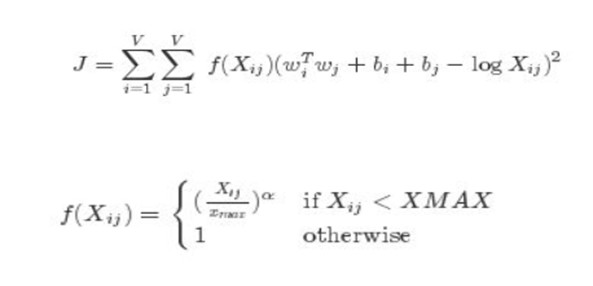

## Sentential Glove Embeddings

We will be using glove embeddings to generate semantic similarity between question and answer pairs:

- Load a pretrained glove model from Kaggle and convert it to Word2Vec format
- This allows us to use functionalities like word pair similarity etc similar to word2vec
- Apply the same logic of mean pooling (as in previous steps) to generate sentential Glove embeddings
- Use cosine similarity to generate the similarities
- It has to be kept in mind, that the dimensionality of the glove embeddings are used when converting words to embedding space


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
def create_glovevectors(model,content):
    w2vmodel_vectors=[]
    for corp in tqdm(content):
        vec=np.zeros(50)
        val=0
        for word in (corp):
            if word in model.index_to_key:
                vec+=model[word]
                val+=1
            #print(vec)
        if val!=0:
            vec/=val
        w2vmodel_vectors.append(vec)
        
    return w2vmodel_vectors    
def save_and_load_glovemodel(model,word1,word2):
    model.save('word2vec_model.bin')
    loaded_model=KeyedVectors.load('word2vec_model.bin')
    def measure_cosine():
        distance=model.similarity(word1,word2)
        return distance
    def plot_vector(vector):
        plt.plot(model[vector])
        plt.show()
    plot_vector(word1)
    plot_vector(word2)
    return model,measure_cosine()
def w2v_glove_variant():
    glove_file='../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'
    word2vec_output_file = 'glove.6B.100d.txt.word2vec'
    glove_loaded=glove2word2vec(glove_file, word2vec_output_file)
    glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    _,distance=save_and_load_glovemodel(glove_model,'photography','camera')
    qcontent=train_df['question_body'][:40].values.tolist()
    acontent=train_df['answer'][:40].values.tolist()
    glove_qsent_embedding=create_glovevectors(glove_model,qcontent)
    glove_asent_embedding=create_glovevectors(glove_model,acontent)
    cosine_dist=[]
    for i in range(40):
        distance=1-cosine(glove_qsent_embedding[i],glove_asent_embedding[i])
        cosine_dist.append(distance)
    glove_cosine=pd.DataFrame(columns=['Question','Answer','Glove_Similarity'])
    glove_cosine['Question']=qcontent
    glove_cosine['Answer']=acontent
    glove_cosine['W2V_Similarity']=cosine_dist
    glove_cosine.head()
    return glove_cosine
glove_cosine=w2v_glove_variant()
glove_cosine.head()

In [ ]:
glove_cosine.to_csv('../glove_similarities.csv',index=False)
print(len(glove_cosine))
# del glove_cosine

## Graph Walks - Deep Walk

DeepWalk utilizes random path-making through graphs to reveal latent patterns in the network, these patterns are then learned and encoded by neural networks to yield our final embeddings. These random paths are generated in an extremely simple manner: Starting from the target root, randomly select a neighbor of that node, and add it to the path, next you randomly choose a neighbor of that node and continue through the walk until the desired number of steps has been taken. Using the e-commerce example, this repeated sampling of network paths yields a list of product-ids. These ID’s are then treated as if they were tokens in a sentence, and the state-space is learned from them using a Word2Vec model. More succinctly, the DeepWalk process follows the following steps:

- For each node, perform N “random steps” starting from that node
- Treat each walk as a sequence of node-id strings
- Given a list of these sequences, train a word2vec model using the Skip-Gram algorithm on these string sequences

<img src="https://miro.medium.com/max/426/1*qT3x8XkY44iLbxhNcF3p2Q.png">

## Graph Embeddings


<img src="https://miro.medium.com/max/2792/1*3pmstIOig4Qc3lrQS4xrNg.png">

We can see that word2vec can already embed graphs, but a very specific type of them.
Most graphs though, aren’t that simple, they can be (un)directed, (un)weighted, (a)cyclic and are basically much more complex in structure than text.
In order to solve that, node2vec uses a tweakable (by hyperparameters) sampling strategy, to sample these directed acyclic subgraphs. This is done by generating random walks from each node of the graph. 

Node2vec’s sampling strategy, accepts 4 arguments:
- Number of walks: Number of random walks to be generated from each node in the graph
- Walk length: How many nodes are in each random walk
- P: Return hyperparameter
- Q: Inout hyperaprameter

and also the standard skip-gram parameters (context window size, number of iterations etc.)
The first two hyperparameters are pretty self explanatory.
The algorithm for the random walk generation will go over each node in the graph and will generate <number of walks> random walks, of length <walk length>.
Q and P, are better explained with a visualization.
Consider you are on the random walk, and have just transitioned from node <t> to node <v> in the following diagram (taken from the article).


In [ ]:
import networkx as nx
g= nx.Graph()
train_df=glove_cosine
print(len(glove_cosine))
logic=[]
print(train_df['W2V_Similarity'].values.tolist())
color_map=[]
for i in train_df['W2V_Similarity']:
    if i<0.99:
        logic.append(0)
        color_map.append('orange')
    else:
        logic.append(1)
        color_map.append('red')

train_df['Label']=logic
train_df['Color']=color_map
starter_g=nx.from_pandas_edgelist(train_df[:],source='Question',target='Label')
nx.draw(starter_g,node_color=range(starter_g.number_of_nodes()))


## Creating the DeepWalk

For this, we will be utilizing neighborhood of 4 nodes connected to a particular node for retrieving representations. Hence the embeddings generated through this method will be based on the locality of 4 surrounding nodes starting a walk from each node. The greater the number of walk steps, the greater would be the impact on the node embeddings. We then apply the Word2Vec wrapper on top of the random walks to generate a skipgram based training sample. This model will have a negative skipgram sampling rate of 10 and would be trained for 20 epochs. Since word2vec is used, we can safely assume that the functionalities like getting the closest matches and simialrities will be similar to the ones shown before.

Some articles for deep walks and the corresponding paper are linked:

- [Paper](https://arxiv.org/abs/1403.6652)
- [Blog](https://www.analyticsvidhya.com/blog/2019/11/graph-feature-extraction-deepwalk/)
- [Blog](https://towardsdatascience.com/deepwalk-its-behavior-and-how-to-implement-it-b5aac0290a15)
- [Gensim](https://github.com/RaRe-Technologies/gensim/tree/develop/gensim/models)


In [ ]:
import random
def get_random_walk(graph, node, n_steps= 4):
    local_path = [str(node),]
    target_node = node
    for _ in range(n_steps):
        neighbors = list(nx.all_neighbors(graph, target_node))
        target_node = random.choice(neighbors)
        local_path.append(str(target_node))
    return local_path
walk_paths = []
for node in tqdm(starter_g.nodes()):
    for _ in range(10):
        walk_paths.append(get_random_walk(starter_g, node))
        
print('Random walk on a sample:',walk_paths[0])

embedder = Word2Vec(
   window=4, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0001,    
   seed=42
)
print('Model Specifications:',embedder)
embedder.build_vocab(walk_paths, progress_per=2)
embedder.train(
   walk_paths, total_examples=embedder.corpus_count, epochs=20, 
   report_delay=1
)
#_,distance=save_and_load_glovemodel(deepwalk_model,'photography','camera')
#print(distance)

deepwalk_vocab=embedder.wv.index_to_key
#display_distance(embedder,10,50,50)

## Getting Similar questions 

DeepWalks are significantly important for generating social network representations and these capture representations based on the degree of depth in a graph with respect to a node. Algorithms like BFS and DFS are used as alternate strategies to attain significant features (global and local representations) with respect to a given node. A typical representation of the flow of randomized deep walks with given skipgram sampling is shown below:

<img src="https://miro.medium.com/max/4005/1*j-P55wBp5PP9oqrxDxdDpw.png">

The steps which are followed in this include:

- We first encode the graph network with the latent representations corresponding to each question sentences
- After generating the embeddings from the negative skipgram based w2v model, we retrieve the top n most similar questions
- We append the scores of these n similar questions with respect to the provided question to generate a representational graph
- We can either plot these on matplotlib to view the heuristic of the match and the similarities generated at a sentential level.
- The same concept can be used to match the answer pairs for a corresponding question but here we are using it through graph embeddings.


In [ ]:
similar_questions=[]
scores=[]
def get_ranking_fromgraph(vocab,embedder,steps):
    vals=embedder.wv.most_similar(vocab)[:steps]
    for context,score in (vals):
        context=str(context)[:]
        similar_questions.append(context)
        scores.append(score)
    return similar_questions,scores
print('Context Question',deepwalk_vocab[30])
vocab=deepwalk_vocab[12]
similar_questions,scores=get_ranking_fromgraph(vocab,embedder,steps=10)
deepwalk_context=pd.DataFrame(columns=['Sample_Question','Similar_Question','Score'])
deepwalk_context['Sample_Question']=[vocab]*10
deepwalk_context['Similar_Question']=similar_questions
deepwalk_context['Score']=scores
edges = pd.DataFrame({'source': deepwalk_context['Sample_Question'],
                              'target': deepwalk_context['Similar_Question'],
                              'weight': deepwalk_context['Score']})
#print(len(scores),len(vocab))
g=nx.from_pandas_edgelist(deepwalk_context,source='Sample_Question',target='Similar_Question',edge_attr='Score')
nx.draw(g,node_color=range(g.number_of_nodes()),with_labels=True)
deepwalk_context.to_csv('../deepwalk_similarities.csv',index=False)
print(deepwalk_context['Score'][0])
deepwalk_context.head()


## Use the plotly module to generate graphs

Since we already have the graph modified by the deepwalk algorithm, we can display it in a more efficient manner. The plotly library provides us with a utility to generate such graphs and some resources to generate such interactive plottings are provided:

- [Plotly](https://plotly.com/python/)
- [Dash](https://plotly.com/python/ai-ml/)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
G=g
pos = nx.spring_layout(G, k=0.5, iterations=50)
for n, p in pos.items():
    G.nodes[n]['pos'] = p
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>DeepWalk Question Similarity',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)
#plotly.plot(fig)


## Node2Vec

Node2vec is another graph embedding algorithm which focuses on retrieving representations from neighbours using random walks but uses a BFS /DFS and degree heuristic for efficient matching. The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence.

<img src="https://snap.stanford.edu/node2vec/walk.png">


After transitioning to node v from t, the return hyperparameter, p and the inout hyperparameter, q control the probability of a walk staying inward revisiting nodes (t), staying close to the preceeding nodes (x1), or moving outward farther away (x2, x3). Homophily is extracted from the graph efficiently.

<img src="https://snap.stanford.edu/node2vec/homo.png">

Resources:

- [Paper](http://arxiv.org/abs/1607.00653)
- [Github](https://github.com/snap-stanford/snap/tree/master/examples/node2vec)


In [ ]:
!pip install node2vec
from node2vec import Node2Vec
node2vec = Node2Vec(starter_g, dimensions=20, walk_length=16, num_walks=100)
model=node2vec.fit(window=10,min_count=2)
vocab=model.wv.index_to_key[12]
similar_questions,scores=get_ranking_fromgraph(vocab,model,18)
nodewalk_context=pd.DataFrame(columns=['Sample_Question','Similar_Question','Score'])
nodewalk_context['Sample_Question']=[vocab]*len(similar_questions)
nodewalk_context['Similar_Question']=similar_questions
nodewalk_context['Score']=scores
edges = pd.DataFrame({'source': nodewalk_context['Sample_Question'],
                              'target': nodewalk_context['Similar_Question'],
                              'weight': nodewalk_context['Score']})
#print(len(scores),len(vocab))
node_g=nx.from_pandas_edgelist(nodewalk_context,source='Sample_Question',target='Similar_Question',edge_attr='Score')
nx.draw(node_g,node_color=range(node_g.number_of_nodes()))
nodewalk_context.to_csv('../nodewalk_similarities.csv',index=False)
print(nodewalk_context['Score'][0])
nodewalk_context.tail()


## Generate similar question pairs and plot them

Here also, we apply the Node2vec algorithm to generate the graph embeddings and get the embedding space of the questions. The embeddings are then compared with each other to generate the similar pairs, in this case 18 nodes in the neighborhood are considered for generating the simialrities. The dimension in Node2vec ensures the dimensions of the embedding space and the walk length is speciified as 16 which includes 16 node representations. As before we will be using the plotly library to plot the graphs.

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
G=node_g
pos = nx.spring_layout(G, k=0.5, iterations=50)
for n, p in pos.items():
    G.nodes[n]['pos'] = p
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Node2Vec Question Similarity',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)
#plotly.plot(fig)


## Poincare Hyperbolic Embeddings

These embeddings follow distinct hyperbolic trajectory and are represented inside a poincare ball. These embeddings are not Euclidean and these come under the Hyperbolic space where the shortest distance inside the Poincare ball is a geodesic. In case of large social networks which are inherently graphs or trees, the children count increases exponentially as the depth increases and representations like these are best suited for poincare model. This is because the Reiman space also increases exponentially with the depth of a tree and can provide sample space for the embeddings. All representations of these embeddings come under the ball shown below:

<img src="https://s3.ap-south-1.amazonaws.com/techleerimages/8435c41a-a112-41f7-88c0-b8edb0d4365c.jpg">


The optimization pattern for these embeddings involve normalizing or reducing the geodesic distance between similar words or tokens. The generic formulae for a geodesic distance inside the Poincare ball:

<img src="https://i.imgur.com/hzmELh6.png">

Once the distance is retrieved, we can apply previous methods of determining similarities. According to the [paper](https://arxiv.org/pdf/1705.08039.pdf), the following execerpt is important:
```
We assume that there exists a latent hierarchy
in which the symbols can be organized. In addition to the similarity of objects, we intend to also
reflect this hierarchy in the embedding space to improve over existing methods in two ways:
1. By inducing an appropriate bias on the structure of the embedding space, we aim at learning
more parsimonious embeddings for superior generalization performance and decreased
runtime and memory complexity.
2. By capturing the hierarchy explicitly in the embedding space, we aim at gaining additional
insights about the relationships between symbols and the importance of individual symbols.
```
All embeddings covered through this method can be applied in the Euclidean domain as well (which we are seeing in our example). These generalized embedding patterns are used extensively in Facebook.

In [ ]:
from gensim.models.poincare import PoincareModel
import networkx as nx
from matplotlib import pyplot
train_df=pd.read_csv('../input/google-quest-challenge/train.csv')
qcontent=train_df['question_body'][:100].values.tolist()
acontent=train_df['answer'][:100].values.tolist()
initial_relations=[(qcontent[i],acontent[i]) for i in range(20)]
online_representation=[(qcontent[i],acontent[i]) for i in range(20,40)]
def display_distance(loaded_model,num,x,y):
    pca = PCA(n_components=2)
    transformation_model=loaded_model.kv[loaded_model.kv.index_to_key]
    result = pca.fit_transform(transformation_model[:num])
    pyplot.figure(figsize=(x,y))
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(loaded_model.kv.index_to_key)
    for i, word in enumerate(words[:num]):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()
def poincare(initial_relations,online_representation):
    model=PoincareModel(initial_relations,negative=2)
    model.train(epochs=20)
    #display_distance(model,10,50,50)
    def online_representations(model,online_representation):
        model.build_vocab(online_representation, update=True)
        model.train(epochs=20)
        #display_distance(model,10,50,50)
        return model
    print('Online learning')
    updated_model=online_representations(model,online_representation)
    return model,updated_model
def get_ranking_fromgraph(vocab,model,steps):
    similar_questions,scores=[],[]
    vals=model.kv.most_similar(vocab)[:steps]
    for context,score in (vals):
        context=str(context)[:]
        similar_questions.append(context)
        scores.append(score)
    return similar_questions,scores
print('vocab',qcontent[4])
vocab=qcontent[6]
_,model=poincare(initial_relations,online_representation)
similar_answers,scores=get_ranking_fromgraph(vocab,model,6)
poincare_context=pd.DataFrame(columns=['Sample_Question','Similar_Answer','Score'])
poincare_context['Sample_Question']=[vocab]*len(similar_answers)
poincare_context['Similar_Answer']=similar_answers
poincare_context['Score']=scores
# edges = pd.DataFrame({'source': nodewalk_context['Sample_Question'],
#                               'target': nodewalk_context['Similar_Question'],
#                               'weight': nodewalk_context['Score']})
#print(len(scores),len(vocab))
poincare_g=nx.from_pandas_edgelist(poincare_context,source='Sample_Question',target='Similar_Answer',edge_attr='Score')
nx.draw(poincare_g,node_color=range(poincare_g.number_of_nodes()),with_labels=True)
poincare_context.to_csv('../poincare_similarities.csv',index=False)
print(poincare_context['Score'][0])
poincare_context.tail()
    

In [ ]:
del model

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
G=poincare_g
def plotter(G,title):
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    for n, p in pos.items():
        G.nodes[n]['pos'] = p
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5,color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='RdBu',
            reversescale=True,
            color=[],
            size=15,
            colorbar=dict(
                thickness=10,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=0)))

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color']+=tuple([len(adjacencies[1])])
        node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
        node_trace['text']+=tuple([node_info])
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=title,
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    iplot(fig)
plotter(G,'Poincare embedding')

## Model Building

In this case, we will be focussing on creating models for generic classification. We can use either of the vectorized embeddings from the above mentioned methods for our models. Since we have to classify statistically the question answer pair, it is best suited to use the embeddings extracted from the above mentioned approaches. However the loss function for any statistical model can be tweaked for our use case. Primarily we will be focussing on forests and tree based algorithms like gradient boosting/ decision trees etc. The reason for choosing these as the starting point is because, decision tree counterparts offer a better representation by using standardised entropy selection techniques.Also the resultant space is not binomial but multinomial and hence logistic regression based approaches may not be well suited in this case.

## Brief Introduction of Statistical Models


This is going to be a brief introduction of different statistical models which will be used simultaeneously with k fold and cross validation techniques for examining the accuracy of the models. In this case, we will be focussing on accuracy as the major KPI and later we will be running on different observations such as f1,ROC etc.


### Decision Trees

[Decision Trees](https://scikit-learn.org/stable/modules/tree.html) is a supervised model for classification/regression. This works on creating decision branches which evolves a criteria and is often acknowledged as a simplistic classification (white box) model as the stages of decision can be easily derived. A regression tree appears as follows:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_0011.png">

The [algorithms](https://scikit-learn.org/stable/modules/tree.html) include ID3,C4.5/C5.0,CART which can be analysed as follows:

- ID3(Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalise to unseen data.

- C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. These accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule’s precondition if the accuracy of the rule improves without it.

- C5.0 is Quinlan’s latest version release under a proprietary license. It uses less memory and builds smaller rulesets than C4.5 while being more accurate.

- CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.


In general, the major logics involved in Decision Trees involves computation of Entropy or Gini Index, which is as follows:

<img src="https://qph.fs.quoracdn.net/main-qimg-690a5cee77c5927cade25f26d1e53e77">

Typically a Gini Coefficient  is evaluated as the area between the ```y=x``` line and Lorentz curve

<img src="https://i.stack.imgur.com/iawuF.jpg">


Misclassification is another criteria:

<img src="https://miro.medium.com/max/2180/1*O5eXoV-SePhZ30AbCikXHw.png">

Typically a decision tree appears as follows:

<img src="https://scikit-learn.org/stable/_images/iris.png">

Some resources:

- [Blog](https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d)
- [Blog](https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/)
- [Blog](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/)



### Random Forests 


[Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the ```max_samples``` parameter ```if bootstrap=True (default)```, otherwise the whole dataset is used to build each tree. When splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size ```max_features```. (See the parameter tuning guidelines for more details).The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

<img src="https://www.researchgate.net/profile/Hung_Cao12/publication/333438248/figure/fig6/AS:763710377299970@1559094151459/Random-Forest-model-with-majority-voting.ppm">


### Gradient Boosting Forests and Trees

[Gradient Boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) is a central part of ensemble modelling in sklearn.

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

- In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

  Examples: Bagging methods, Forests of randomized trees

- By contrast, in boosting methods, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

  Examples: AdaBoost, Gradient Tree Boosting


Pictorially these can be represented as :

<img src="https://miro.medium.com/max/3908/1*FoOt85zXNCaNFzpEj7ucuA.png">


Several Boosting Models can be found under this criteria:

#### [AdaBoosting](https://blog.paperspace.com/adaboost-optimizer/#:~:text=AdaBoost%20is%20an%20ensemble%20learning,turn%20them%20into%20strong%20ones.): 
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights  to each of the training samples. Initially, those weights are all set to (1/N), so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_adaboost_hastie_10_2_0011.png">


### [LightGBM](https://lightgbm.readthedocs.io/en/latest/)

Light GBM is another gradient boosting strategy which relies on trees.It has the following advantages:

- Faster training speed and higher efficiency.

- Lower memory usage.

- Better accuracy.

- Support of parallel and GPU learning.

- Capable of handling large-scale data.

LightGBM grows leaf-best wise and will choose the leaf with maximum max delta loss to grow.

<img src="https://lightgbm.readthedocs.io/en/latest/_images/leaf-wise.png">


Some resources:

- [XGB](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Blogs](https://www.analyticsvidhya.com/blog/tag/gradient-boosting/)

## Application of models

Most of the statistical models rely on encoded labels so that it can make predictions or provide the predicted logits. In our case, the category column can be encoded in such a manner as it falls inside a certain bound of labels. However the answer embeddings from word2vec cannot be directly used for statistical models as these are returned in the form of multi dimensional tensors which cannot be encoded as labels.Each question has a different pattern of answers and hence it is not possible to have as many combinations of labels as there are in the inputs. There are some alternatives:

Approach 1:

- We can encode category column and use a regressive/boosting model for testing with the question embeddings
- We can encode the category column and use the model for testing with answer embeddings
- Compute the similarity/match of the question and answer pairs based on the category labels

Approach 2:

- We can distinguish the labels based on cosine similarity which we calculated earlier on Euclidean space
- This can be further extended to multinomial logical encodings
- Apply stat models and run inference




In [ ]:
import tensorflow as tf
qcontent=train_df['question_body'][:1000].values.tolist()
w2v_qsent_embedding=create_w2vvectors(model,qcontent)
acontent=train_df['answer'][:1000].values.tolist()
w2v_asent_embedding=create_w2vvectors(model,acontent)

In [ ]:
w2v_cosine=w2v_simi(w2v_qsent_embedding,w2v_asent_embedding,1000)
logic=[]
for i in range(len(w2v_cosine)):
    if w2v_cosine['W2V_Similarity'][i]>=0.9945:
        logic.append(1)
    else:
        logic.append(0)
w2v_cosine['Logic']=logic
w2v_cosine.head()
        

In [ ]:
from xgboost import XGBClassifier as xg
from lightgbm import LGBMClassifier as lg
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
def multi_logloss(actual, predicted, eps):
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2
    '''sum(-ylogy)'''
    clip = tf.experimental.numpy.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    result = tf.experimental.numpy.sum(actual * tf.math.log(clip))
    
    return -1.0 / rows * result
#print(len(w2v_asent_embedding))
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df['category'][:1000].values)
train_x, valid_x, train_y, valid_y = train_test_split(w2v_qsent_embedding, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.20, shuffle=True)
print(len(train_x),len(train_y))
models=[]
#models.append(('LogisticRregression',LogisticRegression(C=1.0,penalty='l2')))
models.append(('KNearestNeighbors',KNeighborsClassifier()))
models.append(('DecisionTree',DecisionTreeClassifier(criterion='entropy')))
#models.append(('RandomForestRegressor',RandomForestRegressor(n_estimators = 1000, random_state = 42)))
#models.append(('RandomForestClassifier',RandomForestClassifier(n_estimators = 1000, criterion='gini')))
models.append(('GradientBoostClassifier',GradientBoostingClassifier(learning_rate=1e-2, loss='deviance',n_estimators=100)))
models.append(('AdaBoostClassifier',AdaBoostClassifier(learning_rate=1e-2,algorithm='SAMME.R',n_estimators=100)))
models.append(('ExtraTreesClassifier',ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2)))
models.append(('BagClassifier',BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)))
# models.append(('HistGradientBoostClassifier',HistGradientBoostingClassifier(max_iter=100)))
# models.append(('SupportVectorClassifier',SVC(C=1.0,kernel='sigmoid')))
model_result=[]
model_name=[]
loss=[]
acc=[]
scoring='accuracy'
print("Statistical Model TFIDF- Baseline Evaluation")
for name,model in tqdm(models):
    model_name.append(model)
    kfold=KFold(n_splits=10,random_state=None)
    results=cross_val_score(model,train_x,train_y,cv=kfold)
    print("=======================")
    print("Classifiers: ",name, "Has a training score of", round(results.mean(), 2) * 100, "% accuracy score")
    model.fit(train_x,train_y)
    predictions=model.predict_proba(valid_x)
    logloss=multi_logloss(valid_y,predictions,1e-10)
    loss.append(logloss)
    print('Multiclass_logloss:',logloss)
    pred=model.predict(valid_x)
    acc_sc=accuracy_score(valid_y,pred)
    acc.append(acc_sc)
    print('Accuracy Score:',acc_sc)
    model_result.append(results.mean())



In [ ]:
model_stats=pd.DataFrame(columns=['Model_Name','Training Accuracy','Log Loss'])
model_stats['Model_Name']=model_name
model_stats['Training Accuracy']=model_result
model_stats['Log Loss']=loss
model_stats.to_csv('../w2v_training.csv',index=False)
model_stats.head()

In [ ]:
'''Run the same code for matching the answer embeddings with the labels
'''

train_x, valid_x, train_y, valid_y = train_test_split(w2v_asent_embedding, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.20, shuffle=True)
print(len(train_x),len(train_y))
models=[]
#models.append(('LogisticRregression',LogisticRegression(C=1.0,penalty='l2')))
models.append(('KNearestNeighbors',KNeighborsClassifier()))
models.append(('DecisionTree',DecisionTreeClassifier(criterion='entropy')))
#models.append(('RandomForestRegressor',RandomForestRegressor(n_estimators = 1000, random_state = 42)))
#models.append(('RandomForestClassifier',RandomForestClassifier(n_estimators = 1000, criterion='gini')))
models.append(('GradientBoostClassifier',GradientBoostingClassifier(learning_rate=1e-2, loss='deviance',n_estimators=100)))
models.append(('AdaBoostClassifier',AdaBoostClassifier(learning_rate=1e-2,algorithm='SAMME.R',n_estimators=100)))
models.append(('ExtraTreesClassifier',ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2)))
models.append(('BagClassifier',BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)))
# models.append(('HistGradientBoostClassifier',HistGradientBoostingClassifier(max_iter=100)))
# models.append(('SupportVectorClassifier',SVC(C=1.0,kernel='sigmoid')))
model_result=[]
model_name=[]
loss=[]
acc=[]
scoring='accuracy'
print("Statistical Model TFIDF- Baseline Evaluation")
for name,model in tqdm(models):
    model_name.append(model)
    kfold=KFold(n_splits=10,random_state=None)
    results=cross_val_score(model,train_x,train_y,cv=kfold)
    print("=======================")
    print("Classifiers: ",name, "Has a training score of", round(results.mean(), 2) * 100, "% accuracy score")
    model.fit(train_x,train_y)
    predictions=model.predict_proba(valid_x)
    logloss=multi_logloss(valid_y,predictions,1e-10)
    loss.append(logloss)
    print('Multiclass_logloss:',logloss)
    pred=model.predict(valid_x)
    acc_sc=accuracy_score(valid_y,pred)
    acc.append(acc_sc)
    print('Accuracy Score:',acc_sc)
    model_result.append(results.mean())



In [ ]:
model_astats=pd.DataFrame(columns=['Model_AName','Training AAccuracy','Log ALoss'])
model_astats['Model_AName']=model_name
model_astats['Training AAccuracy']=model_result
model_astats['Log ALoss']=loss
model_astats.to_csv('../w2v_atraining.csv',index=False)
model_astats.head()

In [ ]:
model_qstats=pd.read_csv('../w2v_training.csv')
merged_dataframe=pd.concat([model_qstats,model_astats])

In [ ]:
model,_=poincare(initial_relations,online_representation)
initial_relations=[(qcontent[i],acontent[i]) for i in range(20)]
q_embedding,a_embedding=[],[]
for i in range(20):
    embed_q=model.kv[qcontent[i]]
    embed_a=model.kv[acontent[i]]
    q_embedding.append(embed_q)
    a_embedding.append(embed_a)
print(len(q_embedding))
y=y[:20]
train_x, valid_x, train_y, valid_y = train_test_split(q_embedding, y, 
                                                  #stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.5, shuffle=True)
print(len(train_x),len(train_y))
models=[]
#models.append(('LogisticRregression',LogisticRegression(C=1.0,penalty='l2')))
models.append(('KNearestNeighbors',KNeighborsClassifier()))
models.append(('DecisionTree',DecisionTreeClassifier(criterion='entropy')))
#models.append(('RandomForestRegressor',RandomForestRegressor(n_estimators = 1000, random_state = 42)))
#models.append(('RandomForestClassifier',RandomForestClassifier(n_estimators = 1000, criterion='gini')))
models.append(('GradientBoostClassifier',GradientBoostingClassifier(learning_rate=1e-2, loss='deviance',n_estimators=100)))
models.append(('AdaBoostClassifier',AdaBoostClassifier(learning_rate=1e-2,algorithm='SAMME.R',n_estimators=100)))
models.append(('ExtraTreesClassifier',ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2)))
models.append(('BagClassifier',BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)))
# models.append(('HistGradientBoostClassifier',HistGradientBoostingClassifier(max_iter=100)))
# models.append(('SupportVectorClassifier',SVC(C=1.0,kernel='sigmoid')))
model_result=[]
model_name=[]
loss=[]
acc=[]
scoring='accuracy'
print("Statistical Model TFIDF- Baseline Evaluation")
for name,model in tqdm(models):
    model_name.append(model)
    kfold=KFold(n_splits=10,random_state=None)
    results=cross_val_score(model,train_x,train_y,cv=kfold)
    print("=======================")
    print("Classifiers: ",name, "Has a training score of", round(results.mean(), 2) * 100, "% accuracy score")
    model.fit(train_x,train_y)
    #predictions=model.predict_proba(valid_x)
    #logloss=multi_logloss(valid_y,predictions,1e-10)
    #loss.append(logloss)
    #print('Multiclass_logloss:',logloss)
    pred=model.predict(valid_x)
    acc_sc=accuracy_score(valid_y,pred)
    acc.append(acc_sc)
    print('Accuracy Score:',acc_sc)
    model_result.append(results.mean())

